<a href="https://colab.research.google.com/github/dnhshl/cc-ai/blob/main/simpleRobot_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# simpleRobot
Neuronales Netz zur Berechnung der inversen Kinematik eines (sehr einfachen) Roboters mit zwei Freiheitsgraden.

Wir simulieren die Freiheitsgrade eines Armes, der sich im Schultergelenk und im Ellenbogengelenk drehen kann.





<img src='https://github.com/dnhshl/cc-ai/blob/main/images/robot.PNG?raw=1' width="500">




Die kartesischen Koordinaten $(x,y)$ berechnen sich aus den Winkeln $q_1, q_2$ der Roboterarme wie folgt (bitte einmal selbst nachvollziehen!)

$$
x = l_1 \cos(q_1) + l_2 \cos(q_1 + q_2)\\
$$
$$
y = l_1 \sin(q_1) + l_2 \sin(q_1 + q_2)
$$

Die Berechnung der Endposition des Roboterarms bei bekannten Winkeln nennt man **Vorwärtskinematik**. Das ist einfach.

Komplizierter, aber in der Anwendung natürlich wichtiger, ist die **Rückwärtskinematik**. Welche Winkel muss ich einstellen, um eine bestimmte vorgegebene Position erreichen zu können. Für eine geschlossene Lösung müsste man die obigen Gleichungen nach $q_1$ und $q_2$ auflösen. Das ist nicht ganz einfach möglich.

Wir wollen daher ein neuronales Netz trainieren, das diese Aufgabe für uns löst. Also

  * Input $(x,y)$
  * Output $(q_1, q_2)$.

Das ist ein Regressionsproblem.

## Lade notwendige Libraries


In [1]:
!pip install torchinfo -q
from torchinfo import summary
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import copy
import tqdm
from sklearn.model_selection import train_test_split

# Daten

Generiere Trainingsdaten. Das ist hier sehr einfach, da bei bekannten Winkeln `q1` und `q2` die `x` und `y` Position berechnet werden kann.

Der Oberarm kann im Schultergelenk ca. um einen Winkel `q1` zwischen -110 .. 20 Grad  und `q2` im Ellenbogengelenk zwischen 0 .. 90 Grad bewegt werden. Der Einfachheit halber nehmen wir weiterhin an, dass die Oberarmlänge `l1 = 30 cm` und die Unterarmlänge `l2 = 30 cm` sind.

## Hilfsfunktion zur Berechnung der Vorwärts-Kinematik

In [2]:
l1 = 0.3  # Länge des ersten Roboterarms
l2 = 0.3  # Länge des zweiten Roboterarms

# Berechne die Vorwärtskinematik.
# Input ist ein (m,2) Tensor mit den Winkeln
# Output ist ein (m,2) Tensor mit den karthesischen Koordinaten

def forward_kinematics(q):

  x = l1*torch.cos(q[:,0]) +l2*torch.cos(torch.sum(q,1))
  y = l1*torch.sin(q[:,0]) +l2*torch.sin(torch.sum(q,1))
  return torch.stack((x, y), axis=1)

Anmerkung: Die KI Frameworks (PyTorch, Tensorflow) arbeiten immer mit **Tensoren**. Tensoren sind einfach gesprochen eine Verallgemeinerung von Vektoren / Matrizen, also eine Anordnung von Zahlen entlang n Achsen. Die Zahl n heißt die Stufe des Tensors. Vektoren sind also Tensoren erster Stufe und Matrizen Tensoren zweiter Stufe. Einzelne Zahlen nennt man auch Tensoren nullter Stufe oder Skalare. n kann aber auch höherdimensional (3, 4, ...) sein.
Die Frameworks sind so programmiert, dass mit Tensoren effizient gerechnet werden kann. Es sind keine for-Schleifen notwendig, um über alle Zahlen eines Tensors zu iterieren, sondern die Operationen auf den Zahlen eines Tensors können (auf entsprechender Hardware wie Grafikkarten) alle quasi parallel durchgeführt werden.

## OK, jetzt also die Trainingsdaten

Wir generieren zufällige Trainingsdaten.
Eine alternative Möglichkeit wäre, im (q1, q2) Koordinatensystem gleichmäßig zu samplen. Die Verteilung im karthesischen Koordinatensystem wäre dann aber nicht gleichmäßig.

In [3]:
# Hilfsfunktion zur Generierung von n zufälligen Trainingsdaten (x, y)
# x ist die Position (x1, x2) im Koordinatensystem
# y sind die Winkel (q1, q2), die eingestellt werden müssen,
# um diese Position anzufahren.

def gen_data(n):

  # q1 im Bereich von -110 .. 20 Grad
  q1 = (torch.rand(n) * 130 - 110) / 180 * torch.pi

  # q2 im Bereich von 0 .. 90 Grad
  q2 = (torch.rand(n) * 90) / 180 * torch.pi

  # Kombiniere Vektoren als Matrix
  y = torch.stack([q1,q2]).T

  # Berechne x und y
  x = forward_kinematics(y)

  return(x, y)

In [4]:
n = 20000 # Wie viele Traingsdaten sollen generiert werden?
(x, y) = gen_data(n)

# Wir geben ein paar der Trainingsdaten aus
somedata = np.random.choice(y.shape[0], 5)

print(x[somedata])
print(y[somedata]*180/np.pi)

tensor([[ 0.2521, -0.3723],
        [ 0.5028, -0.3110],
        [-0.0346, -0.5949],
        [ 0.3989,  0.2356],
        [ 0.4402, -0.1623]])
tensor([[ -97.3565,   82.9275],
        [ -41.5576,   19.6356],
        [-100.0106,   13.3683],
        [  -8.8891,   78.9022],
        [ -58.7965,   77.1124]])


## Welcher Bereich `(x1, x2)` kann vom Roboter erreicht werden?

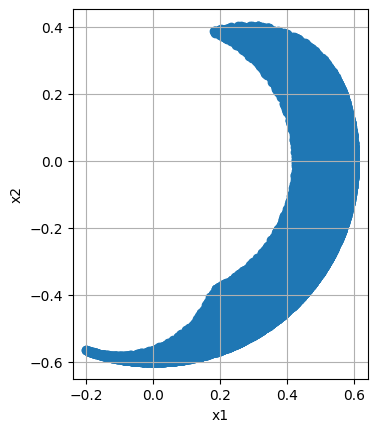

In [5]:

def plot_range():
  plt.figure(1)
  plt.scatter(x[:,0], x[:,1])
  plt.xlabel('x1')
  plt.ylabel('x2')
  #plt.xlim(0,2.5)
  plt.grid(True)
  plt.gca().set_aspect("equal")


plot_range()

# Festlegung unseres Modells

Wir wollen ein Neuronales Netz mit einem hidden Layer verwenden.
Zwei Fully Connected Layer.

Als Fehlerfunktion wird der quadratische Fehler genutzt. Sie können auch [andere Loss Functions](https://pytorch.org/docs/stable/nn.html#loss-functions) ausprobieren.

Als Optimizer verwenden wir Adam.
Testen Sie auch verschiedene [Optimizer](https://pytorch.org/docs/stable/optim.html?highlight=optimizer#torch.optim.Optimizer).

Testen Sie auch alternative Anzahlen von Layern und Layergrößen.

## Netzwerkmodell

In [6]:
# Define the model
model = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 20),
    nn.Tanh(),
    nn.Linear(20, 2)
)
print(model)

Sequential(
  (0): Linear(in_features=2, out_features=30, bias=True)
  (1): Tanh()
  (2): Linear(in_features=30, out_features=20, bias=True)
  (3): Tanh()
  (4): Linear(in_features=20, out_features=2, bias=True)
)


In [7]:

summary(model)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Linear: 1-1                            90
├─Tanh: 1-2                              --
├─Linear: 1-3                            620
├─Tanh: 1-4                              --
├─Linear: 1-5                            42
Total params: 752
Trainable params: 752
Non-trainable params: 0

In [8]:
# safe initial weights for resets
initial_weights = copy.deepcopy(model.state_dict())

In [ ]:
# call this if reset of weights is required
model.load_state_dict(initial_weights)

<All keys matched successfully>

## Loss Function und Optimizer

In [9]:
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.01)

## Split der Daten in Trainings- und Validierungsdaten

In [10]:
# train-validation split of the dataset
x_train, x_valid, y_train, y_valid = train_test_split(x, y, train_size=0.7, shuffle=True)

## Trainingsparameter

In [11]:
# training parameters
n_epochs = 50   # number of epochs to run
batch_size = 256  # size of each batch
batch_start = torch.arange(0, len(x_train), batch_size)

## Trainingsschleife

In [21]:
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history_train = []
history_valid = []

# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            x_batch = x_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    # mse auf Testdaten
    y_pred = model(x_train)
    mse_train = float(loss_fn(y_pred, y_train))
    history_train.append(mse_train)
    # mse auf Validierungsdaten
    y_pred = model(x_valid)
    mse_valid = float(loss_fn(y_pred, y_valid))
    history_valid.append(mse_valid)
    # sichere "beste" Gewichte (Bewertung auf Basis der Validierungsdaten)
    if mse_valid < best_mse:
        best_mse = mse_valid
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)

Epoch 49: 100%|██████████| 55/55 [00:00<00:00, 143.17batch/s, mse=0.00103]


<All keys matched successfully>

MSE: 0.00
RMSE: 0.04


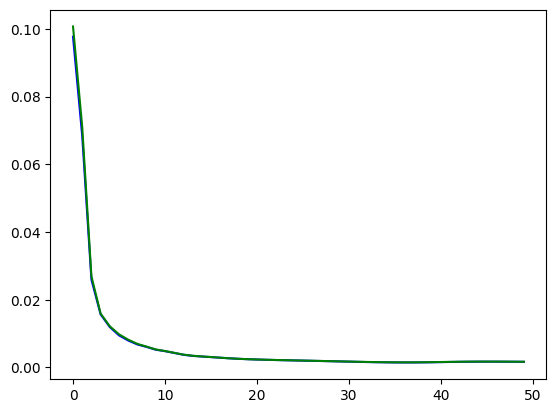

In [13]:
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
t = [i for i in range(len(history_train))]
plt.plot(t, history_train, 'b', t, history_valid, 'g')
plt.show()

## Evaluation mit Testdaten

In [17]:
testdatasize = 1000

(x_test, y_test) = gen_data(testdatasize)



y_pred = model(x_test)

somedata = np.random.choice(y_pred.shape[0], 5)

for d in somedata:
  print(y_pred[d]*180/np.pi, y_test[d]*180/np.pi)





tensor([-35.3920,  44.3963], grad_fn=<DivBackward0>) tensor([-35.0835,  43.6231])
tensor([-21.2664,  43.8184], grad_fn=<DivBackward0>) tensor([-21.0515,  43.7945])
tensor([-3.3050, 66.7756], grad_fn=<DivBackward0>) tensor([-2.9869, 65.0783])
tensor([-99.1617,  68.2206], grad_fn=<DivBackward0>) tensor([-98.1612,  67.0104])
tensor([-58.4592,  66.0113], grad_fn=<DivBackward0>) tensor([-58.0392,  64.3185])


In [18]:
print(forward_kinematics(y_test[somedata]))
print(forward_kinematics(y_pred[somedata]))

mse = loss_fn(y_pred, y_test)
print(mse)

tensor([[ 0.5422, -0.1279],
        [ 0.5567,  0.0082],
        [ 0.4400,  0.2495],
        [ 0.2142, -0.4521],
        [ 0.4570, -0.2217]])
tensor([[ 0.5409, -0.1268],
        [ 0.5566,  0.0062],
        [ 0.4335,  0.2511],
        [ 0.2095, -0.4504],
        [ 0.4543, -0.2163]], grad_fn=<StackBackward0>)
tensor(0.0014, grad_fn=<MseLossBackward0>)


## Teste verschiedene Trajektorien

### Hilfsfunktionen

In [19]:
# Gerade

def gerade(x1, y1, x2, y2):
  t = np.linspace(0,1)
  x = x1 + t*(x2-x1)
  y = y1 + t*(y2-y1)

  return (x, y)


def kreis(x0, y0, R):
  t = np.linspace(0, 2*np.pi)
  x = x0 + R*np.sin(t)
  y = y0 + R*np.cos(t)

  return (x,y)

def parabelbogen(x1,y1,x2,y2):
  t = np.linspace(0,1)
  x = x1 + (x2-x1) * t
  y = y1 + (y2-y1) * t*t

  return (x,y)

def plot_trajectory(t, figure=100, zoom=True):
  (x, y) = t
  plt.figure(figure)
  plt.plot(x,y, label='soll')
  X = torch.stack((torch.from_numpy(x), torch.from_numpy(y)), axis=1).float()
  phipred = model(X)

  pred = forward_kinematics(phipred).detach().numpy()

  plt.plot(pred[:,0], pred[:,1], label='ist')
  plt.grid(True)
  plt.legend()
  plt.gca().set_aspect("equal")
  dx = np.max(x) - np.min(x)
  dy = np.max(y) - np.min(y)
  if zoom:
    plt.xlim(np.min(x)-0.1*dx, np.max(x)+0.1*dx)
    plt.ylim(np.min(y)-0.1*dy, np.max(y)+0.1*dy)
  else:
    plt.xlim(-0.2, 0.6)
    plt.ylim(-0.6, 0.4)





### Plot

<ipython-input-19-04d9bdc98465>:42: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(np.min(y)-0.1*dy, np.max(y)+0.1*dy)


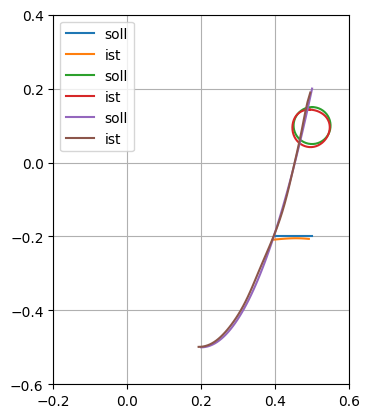

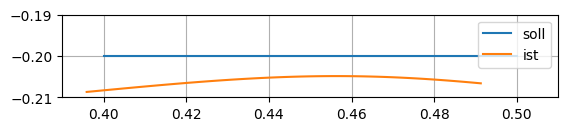

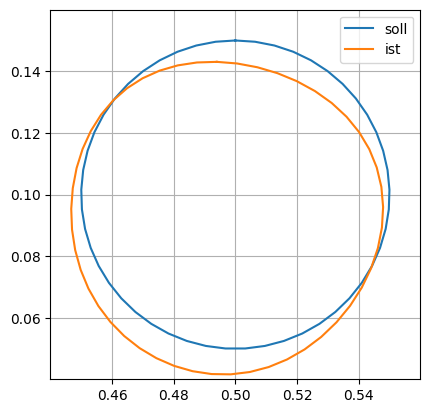

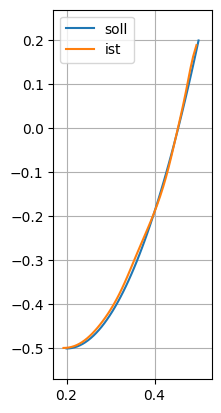

In [22]:
# Alle in einen Plot
plot_trajectory(gerade(0.4,-0.2, 0.5, -0.2), zoom=False)
plot_trajectory(kreis(0.5, 0.1, 0.05), zoom=False)
plot_trajectory(parabelbogen(0.2,-0.5, 0.5, 0.2), zoom=False)


# Einzelplots gezoomt
plot_trajectory(gerade(0.4,-0.2, 0.5, -0.2), figure=2)
plot_trajectory(kreis(0.5, 0.1, 0.05), figure=3)
plot_trajectory(parabelbogen(0.2,-0.5, 0.5, 0.2), figure=4)
